# Cell-wise analyses:reveal dominant interactions across all cells

In this tutorial, we will introduce approaches for gene network motif analysis and guide you to perform cell-wise analyses of SPI1-GATA1 network motif.

Import relevant packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import Scribe as sb
import sys
import os

# import scanpy as sc
import dynamo as dyn
import seaborn as sns

dyn.dynamo_logger.main_silence()


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
adata_labeling = dyn.sample_data.hematopoiesis()

## Three approaches for in-depth network motif characterizations
The schematic graph in this section shows the three approaches.
- cell-wise analyses to reveal dominant interactions across all cells
- trajectory-wise analyses reveal trajectory dependent interactions along a trajectory (predicted either from vector field streamline, or least action path, see Figure 6). 
- Plane-wise analyses reveal direct interactions for any characteristic cell states by varying genes of interest while holding all other genes constant.

In the next section, we will use **cell-wise analyses** to analyze PU.1/SPI1–GATA1 network motif.  

![fig5_h](images/fig5_h.png)

## Cell-wise analyses of the PU.1/SPI1–GATA1 network motif across all cells

### Schematic of the SPI1-GATA1 toggle switch model

![fig5_I_i](images/fig5_I_i.png)

### Streamline plot of the RNA velocities of SPI1 (x-axis) and GATA1 (y-axis)

In [3]:
dyn.configuration.set_pub_style(scaler=4)
dyn.pl.streamline_plot(
    adata_labeling,
    color="cell_type",
    x="SPI1",
    y="GATA1",
    layer="M_t",
    ekey="M_t",
    pointsize=0.5,
    figsize=(8, 5),
    vkey="velocity_alpha_minus_gamma_s",
    s_kwargs_dict={"despline": False, "deaxis": False},
)


/Users/random/dynamo-release/dynamo/plot/scVectorField.py:1711: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [4]:
adata_labeling.uns.keys()

dict_keys(['PCs', 'VecFld_pca', 'VecFld_umap', 'X_umap_neighbors', 'cell_phase_genes', 'cell_type_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'grid_velocity_pca', 'grid_velocity_umap', 'grid_velocity_umap_ori_perturbation', 'grid_velocity_umap_test', 'jacobian_pca', 'leiden', 'neighbors', 'pca_mean', 'pp', 'response', 'SPI1 VS GATA1_colors'])

In [5]:
adata_labeling.uns["jacobian_pca"]['jacobian'].shape

(30, 30, 1947)

- Repression from SPI1 to GATA1, GATA1 to SPI1
- self-activation of SPI1, and GATA1, in the SPI1 and GATA1 expression space

In particular, the repression from SPI1 to GATA1 is mostly discernable in progenitors (rectangle A: bottom left) but becomes negligible when either GATA1 is much higher than SPI1 (rectangle B: upper left) or GATA1 is close to zero (rectangle C: bottom right).

In [6]:
genes = ["SPI1", "GATA1"]
def plot_jacobian_on_gene_axis(receptor, effector, x_gene=None, y_gene=None, axis_layer="M_t", temp_color_key="temp_jacobian_color", ax=None):
    if x_gene is None:
        x_gene = receptor
    if y_gene is None:
        y_gene = effector

    x_axis = adata_labeling[:, x_gene].layers[axis_layer].A.flatten(),
    y_axis = adata_labeling[:, y_gene].layers[axis_layer].A.flatten(),

    dyn.vf.jacobian(adata_labeling, regulators = [receptor, effector], effectors=[receptor, effector])
    J_df = dyn.vf.get_jacobian(
        adata_labeling,
        receptor,
        effector,
    )

    color_values = np.full(adata_labeling.n_obs, fill_value=np.nan)
    color_values[adata_labeling.obs["pass_basic_filter"]] =  J_df.iloc[:, 0]
    adata_labeling.obs[temp_color_key] = color_values

    ax = dyn.pl.scatters(
        adata_labeling,
        vmin=0,
        vmax=100,
        color=temp_color_key,
        cmap="bwr",
        sym_c=True,
        frontier=True,
        sort="abs",
        alpha=0.1,
        pointsize=0.1,
        x=x_axis,
        y=y_axis,
        save_show_or_return="return",
        despline=True,
        despline_sides=["right", "top"],
        deaxis=False,
        ax=ax,
    )
    ax.set_title(r"$\frac{\partial f_{%s}}{\partial x_{%s}}$" % (effector, receptor))
    ax.set_xlabel(x_gene)
    ax.set_ylabel(y_gene)
    adata_labeling.obs.pop(temp_color_key)

figure, axes = plt.subplots(1, 4, figsize=(15, 3))
plot_jacobian_on_gene_axis("GATA1", "SPI1", x_gene="SPI1", y_gene="GATA1", ax=axes[0])
plot_jacobian_on_gene_axis("SPI1", "GATA1", x_gene="GATA1", y_gene="SPI1", ax=axes[1])
plot_jacobian_on_gene_axis("SPI1", "SPI1", x_gene="SPI1", y_gene="GATA1", ax=axes[2])
plot_jacobian_on_gene_axis("GATA1", "GATA1", x_gene="GATA1", y_gene="SPI1",ax=axes[3])
plt.show()


calculating Jacobian for each cell: 100%|██████████| 1947/1947 [00:00<00:00, 135369.66it/s]
/var/folders/m5/dc_kmwcs2_3fqkytr_j09wx00000gn/T/ipykernel_21223/1051771658.py:51: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


### Response heatmap
White dashed lines indicate the minimum or maximum of repression or activation and the corresponding expression threshold.

Transforming subset Jacobian: 100%|██████████| 1947/1947 [00:00<00:00, 127113.97it/s]
/Users/random/dynamo-release/dynamo/plot/heatmaps.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  h = np.array(rep(h, length=2))
/Users/random/dynamo-release/dynamo/plot/heatmaps.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ax[i] = (gx - x[i]) / h[0]
/Users/random/dynamo-release/dynamo/plot/heatmaps.py:124: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

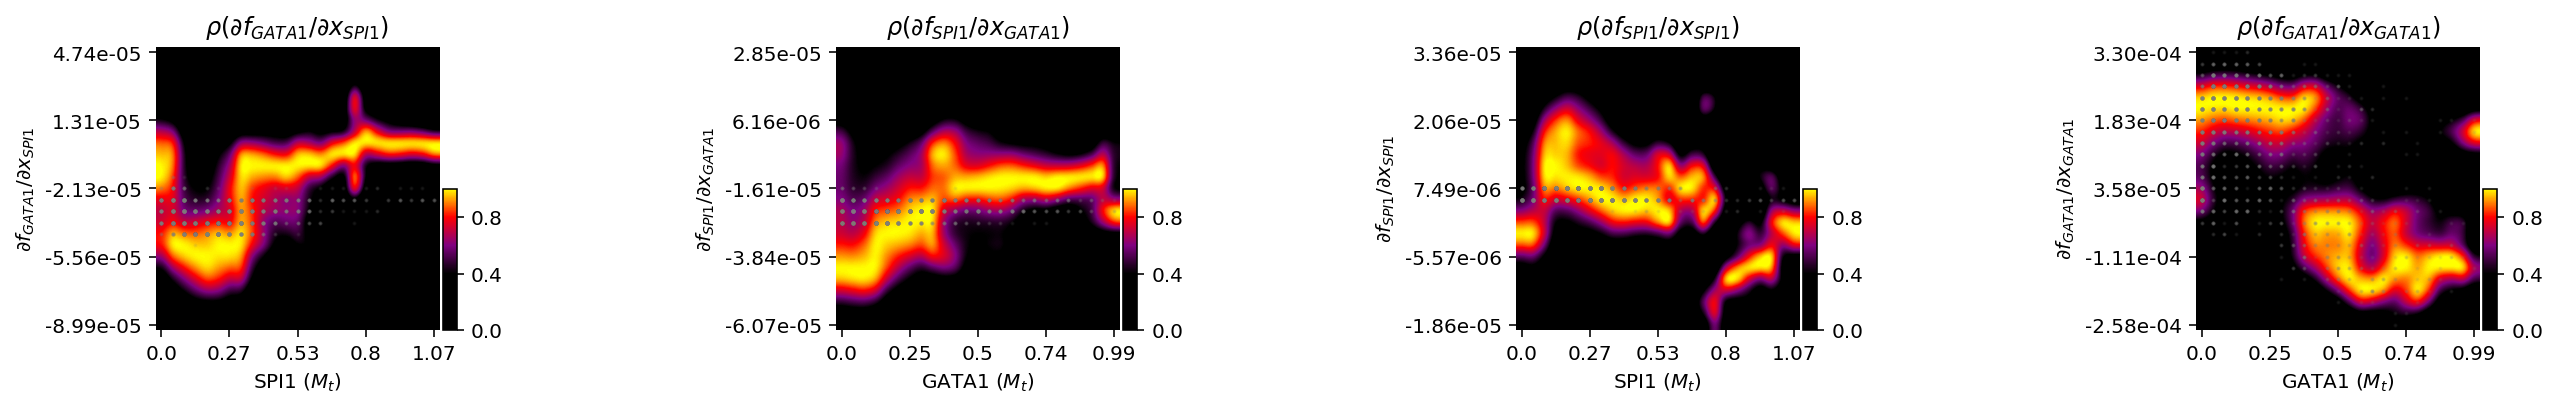

In [24]:
%matplotlib inline

dyn.vf.jacobian(adata_labeling, regulators=["SPI1", "GATA1"], effectors=["SPI1", "GATA1"])
dyn.pl.response(
    adata_labeling,
    np.array([["SPI1", "GATA1"], ["GATA1", "SPI1"], ["SPI1", "SPI1"], ["GATA1", "GATA1"]]),
    ykey="jacobian",
    log=False,
    drop_zero_cells=True,
    grid_num=25,
    figsize=(5, 3),
    save_show_or_return="show"
)